In [1]:
!rm -r DD-GAN-AE
!git clone https://github.com/acse-zrw20/DD-GAN-AE
!pip install ./DD-GAN-AE/
!pip install wandb

rm: cannot remove 'DD-GAN-AE': No such file or directory
Cloning into 'DD-GAN-AE'...
remote: Enumerating objects: 1674, done.
remote: Counting objects: 100% (619/619), done.
remote: Compressing objects: 100% (450/450), done.
remote: Total 1674 (delta 406), reused 363 (delta 169), pack-reused 1055
Receiving objects: 100% (1674/1674), 71.09 MiB | 25.63 MiB/s, done.
Resolving deltas: 100% (1035/1035), done.
Processing ./DD-GAN-AE
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for DD-GAN-AE: filename=DD_GAN_AE-1.0-py3-none-any.whl size=234043 sha256=7ed64cb098d24afbcd5a192c5183ba31f2ece03712d6ab4c809ae56eb1129780
  Stored in direct

In [2]:
! sudo apt-get install texlive-latex-recommended 
! sudo apt install texlive-latex-extra
! sudo apt install dvipng
! sudo apt-get install cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 libkpathsea6
  libpotrace0 libptexenc1 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13
  lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base
Suggested packages:
  fonts-noto poppler-utils ghostscript fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper gv
  | postscript-viewer perl-tk xpdf-reader | pdf-viewer texlive-latex-base-doc
  texlive-latex-recommended-doc texlive-pstricks
The following NEW packages will be installed:
  fonts-d

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Predictive models on slug flow (SF) dataset

Example notebook that displays the functionality of the built package for predicting SF. Note that this notebook assumes that you already have latent variables or want to use the latent variables from the repo. If not, please see the basic_usage_sf notebook for generating latent variables. 

Also, another notebook is included in the github readme for this project (https://github.com/acse-zrw20/DD-GAN-AE) that extends beyond the basic examples of this notebook but is significantly more messy. That notebook also contains an example with the ordinary predictive network.

In [4]:
# All of the necessary external package imports
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import os
import random
from scipy.fft import fft, fftfreq
import six
import matplotlib.patches as patches

tf.config.optimizer.set_jit(True)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

# Built package imports
from ddganAE.utils import calc_pod
from ddganAE.models import (AAE, AAE_combined_loss, CAE, SVDAE, 
                            Predictive_adversarial, Predictive)
from ddganAE.architectures.cae.D3 import *
from ddganAE.architectures.svdae import *
from ddganAE.architectures.discriminators import *

In [5]:
# Setting seeds for reproduceability
seed = 42
tf.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)

## Predictive AAE

### Training the predictive AAE

In [16]:
# Data preprocessing and loading
latent_vars = np.load("/content/drive/MyDrive/Colab Notebooks/data/cae_latent_sf_10vars_800steps_different.npy")
# Also loading the accompanying compressive decoder
compressive_decoder = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/data/cae_model_different-sweep-1/decoder")

train_data = np.moveaxis(latent_vars.reshape(800, 10, 10),
                                    0, 2)

# Scaling the latent variables
scaler = MinMaxScaler((-1, 1))
train_data = scaler.fit_transform(
  train_data.reshape(-1, 1)).reshape(train_data.shape)

In [ ]:
val_data = train_data[:, :, 600:700]
train_data = np.concatenate((train_data[:, :, :600], train_data[:, :, 700:]), axis=2)

In [ ]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.00005, beta_1=0.98, beta_2=0.9)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Training, I recommend doing this on the HPC, the scripts to do that are in
# the HPC folder of this repo. To continue without training just follow the next
# cells as the models are loaded in anyway.

encoder = build_slimmer_dense_encoder(
    100,
    initializer,
    info=False,
    act="relu",
    dropout=0.3
)
decoder = build_slimmer_dense_decoder(
    10,
    100,
    initializer,
    info=False,
    act="relu",
    dropout=0.3,
    final_act="tanh"
)
discriminator = build_custom_discriminator(
    100, initializer, info=False
)

pred_adv = Predictive_adversarial(encoder, decoder, discriminator, 
                                  optimizer)
pred_adv.compile(10, increment=False)
pred_adv.train(
    train_data,
    2000,
    interval=6,
    batch_size=32,
    val_data=val_data,
    wandb_log=False,
    noise_std=0.01,
    n_discriminator=1,
    n_gradient_ascent=15
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
pred_adv.save("model_paae")

INFO:tensorflow:Assets written to: model_paae/encoder/assets
INFO:tensorflow:Assets written to: model_paae/decoder/assets
INFO:tensorflow:Assets written to: model_paae/discriminator/assets


In [ ]:
# Uncomment the below to load a previously trained model
# pred_adv = Predictive_adversarial.from_save("/content/drive/MyDrive/Colab Notebooks/model_paae", optimizer)
# pred_adv.compile(10, increment=False)
# pred_adv.interval = 6

Generate a prediction on the validation part of the dataset

In [ ]:
# Generate a prediction on the val dataset

# Create boundaries and initial values to predict the same grid as the initial
# grid
boundaries = np.zeros((2, 10, 100))
boundaries[0] = val_data[2, :, 0:]
boundaries[1] = val_data[9, :, 0:]

init_values = np.zeros((6, 10))
init_values[:] = np.repeat(val_data[3:9, :, 0], 1, axis=0)

In [ ]:
steps_to_predict = 16 # Predict n timesteps
predicted_latent = pred_adv.predict(boundaries, init_values, steps_to_predict, 
                                    iters=4, sor=1, pre_interval=False)


In [ ]:
# do the inverse transforms
predicted_latent = scaler.inverse_transform(
  predicted_latent.reshape(-1, 1)).reshape(predicted_latent.shape)

true_latent = scaler.inverse_transform(
  val_data.reshape(-1, 1)).reshape(val_data.shape)

# Adding the subdomain 0 back in to go back to 10 subdomains
predicted_latent = np.concatenate((true_latent[0:2, :, :133*6:6], predicted_latent))[:, :, :steps_to_predict]

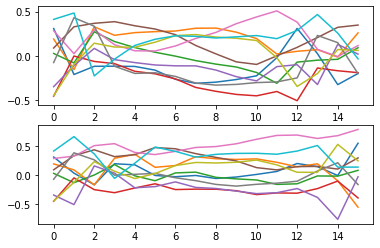

In [ ]:
# Let's plot a reconstruction to see if it visually corresponds to what we expect
fig, ax = plt.subplots(2,1)
ax[0].plot(predicted_latent[4, :, :steps_to_predict].T)
true_latent_interval = true_latent[4, :, :steps_to_predict*6:6]
ax[1].plot(true_latent_interval.T)

In [ ]:
# Decompressing predicted grids
latent_reshaped = np.moveaxis(predicted_latent, 2, 0).reshape(steps_to_predict*10, 10)
predicted_grids = compressive_decoder(latent_reshaped)

In [ ]:
# Loading in the original dataset for comparison
grids = np.load("/content/drive/MyDrive/Colab Notebooks/data/processed/sf_snapshots_800timesteps_notrand.npy")

# Set all >0 to 0 and all <1 to 1 for alpha field
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] < 0)] = 0
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] > 1)] = 1

# Rescale all the velocity fields
scaler = MinMaxScaler()
grids[:,:,:,:,:3] = scaler.fit_transform(grids[:,:,:,:,:3].reshape(-1, 1)).reshape(grids[:,:,:,:,:3].shape)

grids = grids[6000:6960] # Only select validation part of dataset

In [ ]:
# Calculate MSE loss
# Reshaping
grids_reshaped = grids.reshape((int(grids.shape[0]/10), 10, grids.shape[1], grids.shape[2], grids.shape[3], grids.shape[4]))
predicted_grids_reshaped = predicted_grids.numpy().reshape((int(predicted_grids.shape[0]/10), 10, predicted_grids.shape[1], predicted_grids.shape[2], predicted_grids.shape[3], predicted_grids.shape[4]))

print("MSE loss of the prediction on unseen validation dataset: ", np.mean(tf.keras.losses.MSE(grids_reshaped[:steps_to_predict*6:6, 2:10], predicted_grids_reshaped[:, 2:10])))

MSE loss of the prediction on unseen validation dataset:  0.008266529


### Making predictions with the predictive AAE

Here we load in a pretrained model (on many randomly sampled grids and also the entire dataset) and use it to make predictions

In [18]:
# Data preprocessing and loading
latent_vars = np.load("/content/drive/MyDrive/Colab Notebooks/data/cae_latent_sf_10vars_800steps_different.npy")
# Also loading the accompanying compressive decoder
compressive_decoder = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/data/cae_model_different-sweep-1/decoder")
compressive_encoder = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/data/cae_model_different-sweep-1/encoder")

train_data = np.moveaxis(latent_vars.reshape(800, 10, 10),
                                    0, 2)

# Scaling the latent variables
scaler_lat = MinMaxScaler((-1, 1))
train_data = scaler_lat.fit_transform(
  train_data.reshape(-1, 1)).reshape(train_data.shape)

In [9]:
# Load in the (pretrained) model and compile it
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.0005, beta_1=0.98, beta_2=0.99999)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [10]:
# Load in the (pretrained) model and compile it
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.0005, beta_1=0.98, beta_2=0.99999)

vars_latent = 100
nPOD = 10

encoder = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/data/cae_pred_model_clear-sweep-1-6int/encoder") 
decoder = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/data/cae_pred_model_clear-sweep-1-6int/decoder")
discriminator =  discriminator = build_custom_wider_discriminator(
                vars_latent, initializer, info=False
            )
discriminator._name = "NAME"

#Predictive_adversarial.from_save("/content/drive/MyDrive/Colab Notebooks/data/cae_pred_model_clear-sweep-1-6int/", optimizer)

pred_adv = Predictive_adversarial(encoder, decoder, discriminator, optimizer)
pred_adv.compile(nPOD)

pred_adv.interval = 6

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


#### Predicting the original grid

Let's see how the model performs in predicting the original grid (original width and with original number of timesteps)

In [11]:
# Create boundaries and initial values to predict the same grid as the initial
# grid
boundaries = np.zeros((2, 10, 800))
boundaries[0] = train_data[2, :, 0:]
boundaries[1] = train_data[9, :, 0:]

init_values = np.zeros((6, 10))
init_values[:] = np.repeat(train_data[3:9, :, 0], 1, axis=0)

In [19]:
steps_to_predict = 133 # Predict n timesteps
predicted_latent = pred_adv.predict(boundaries, init_values, steps_to_predict, iters=3, sor=1, pre_interval=False, timestep_print_interval=10)

At timestep number  0
At timestep number  10
At timestep number  20
At timestep number  30
At timestep number  40
At timestep number  50
At timestep number  60
At timestep number  70
At timestep number  80
At timestep number  90
At timestep number  100
At timestep number  110
At timestep number  120
At timestep number  130


In [20]:
# do the inverse transforms
predicted_latent = scaler_lat.inverse_transform(
  predicted_latent.reshape(-1, 1)).reshape(predicted_latent.shape)

true_latent = scaler_lat.inverse_transform(
  train_data.reshape(-1, 1)).reshape(train_data.shape)

# Adding the subdomain 0 back in to go back to 10 subdomains
predicted_latent = np.concatenate((true_latent[0:2, :, :134*6:6], predicted_latent))[:, :, :steps_to_predict]

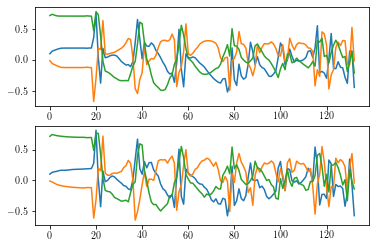

In [21]:
# Let's plot a reconstruction to see if it visually corresponds to what we expect
fig, ax = plt.subplots(2,1)
ax[0].plot(predicted_latent[4, :3, :steps_to_predict].T)
true_latent_interval = true_latent[4, :3, :steps_to_predict*6:6]
ax[1].plot(true_latent_interval.T)

In [22]:
# Decompressing predicted grids
latent_reshaped = np.moveaxis(predicted_latent, 2, 0).reshape(steps_to_predict*10, 10)
predicted_grids = compressive_decoder(latent_reshaped)

In [23]:
# Loading in the original dataset for comparison
grids = np.load("/content/drive/MyDrive/Colab Notebooks/data/processed/sf_snapshots_800timesteps_notrand.npy")

# Set all >0 to 0 and all <1 to 1 for alpha field
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] < 0)] = 0
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] > 1)] = 1

# Rescale all the velocity fields
scaler = MinMaxScaler()
grids[:,:,:,:,:3] = scaler.fit_transform(grids[:,:,:,:,:3].reshape(-1, 1)).reshape(grids[:,:,:,:,:3].shape)

In [24]:
# Reshaping
grids_reshaped = grids.reshape((int(grids.shape[0]/10), 10, grids.shape[1], grids.shape[2], grids.shape[3], grids.shape[4]))
predicted_grids_reshaped = predicted_grids.numpy().reshape((int(predicted_grids.shape[0]/10), 10, predicted_grids.shape[1], predicted_grids.shape[2], predicted_grids.shape[3], predicted_grids.shape[4]))

In [25]:
# Calculate MSE loss
print("MSE loss of the prediction: ", np.mean(tf.keras.losses.MSE(grids_reshaped[:steps_to_predict*6:6, 2:10], predicted_grids_reshaped[:, 2:10])))

MSE loss of the prediction:  0.0015966961


In [26]:
# Save the output
np.save("predicted_grids", predicted_grids[250:350])